Universidad Torcuato Di Tella

Licenciatura en Tecnología Digital\
**Tecnología Digital VI: Inteligencia Artificial**


In [100]:
import os
import torch
import torchaudio
import tarfile
import wandb
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchaudio.datasets import GTZAN
from torch.utils.data import DataLoader
import torchaudio.transforms as tt
from torch.utils.data import random_split
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


# TP3: Encodeador de música



## Orden de pasos

0. Elijan GPU para que corra mas rapido (RAM --> change runtime type --> T4 GPU)
1. Descargamos el dataset y lo descomprimimos en alguna carpeta en nuestro drive.
2. Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos.
3. Visualización de los archivos
4. Clasificación
5. Evaluación




In [101]:
project_name='TP3-TD6'
username = "sansonmariano-universidad-torcuato-di-tella"
wandb.login(key="d2875c91a36209496ee81454cccd95ebe3dc948d")
wandb.init(project = project_name, entity = username)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\45235544\_netrc


In [102]:
random_seed = 42

torch.manual_seed(random_seed)

# Definir parámetros
samplerate = 22050
data_dir = './genres_5sec'

init_batch_size = 20
init_num_epochs = 10
init_lr = 0.0005

In [103]:
# Función para parsear géneros
def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts

# Definir la clase del dataset
class MusicDataset(Dataset):
    def __init__(self, root):
        super().__init__()
        self.root = root
        self.files = []
        for c in os.listdir(root):
            self.files += [os.path.join(root, c, fname) for fname in os.listdir(os.path.join(root, c)) if fname.endswith('.wav')]
        self.classes = list(set(parse_genres(fname) for fname in self.files))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fpath = self.files[idx]
        genre = parse_genres(fpath)
        class_idx = self.classes.index(genre)
        audio = torchaudio.load(fpath)[0]
        return audio, class_idx

In [104]:
# Cargar el dataset
dataset = MusicDataset(data_dir)

# Dividir el dataset en entrenamiento, validación y test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=init_batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=init_batch_size, shuffle=False, num_workers=0)

In [105]:
list_files=os.listdir(data_dir)

classes=[]

for file in list_files:

  name='{}/{}'.format(data_dir,file)

  if os.path.isdir(name):

    classes.append(file)

### 3. Visualización de los archivos

In [106]:
waveform,label= dataset[0]

print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))

shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 8 


shape of spectogram torch.Size([1, 201, 552])


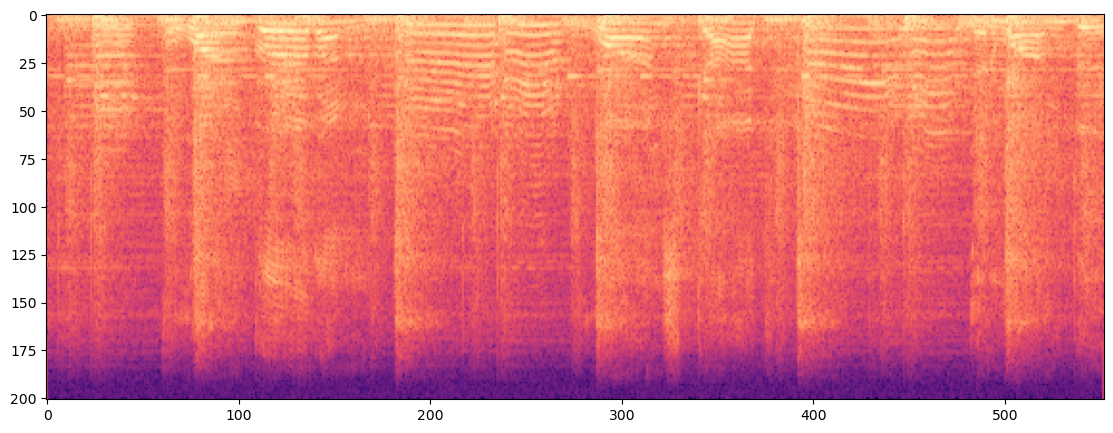

In [107]:
specgram = tt.Spectrogram()(waveform)
print("shape of spectogram {}".format(specgram.size()))

plt.figure(figsize=(20, 5))
plt.imshow(specgram.log2()[0,:,:].numpy(),cmap='magma')

Waveform: tensor([[ 0.0073,  0.0166,  0.0076,  ..., -0.1055, -0.1083, -0.1056]])



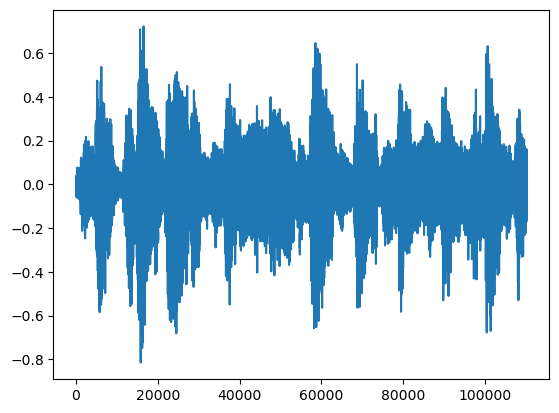

In [108]:
print("Waveform: {}\n".format(waveform))

plt.figure()
plt.plot(waveform.t().numpy())

In [109]:
import IPython
IPython.display.Audio(waveform,rate=samplerate)

### 4. Clasificación

In [110]:
class MLP(nn.Module):
    def __init__(self, n_input, hidden_dim=64, n_output=10):
        super(MLP, self).__init__()
        # Define layers dynamically
        self.fc1 = nn.Linear(n_input, hidden_dim)  # First hidden layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # Second hidden layer
        self.fc3 = nn.Linear(hidden_dim, n_output)  # Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))  # First hidden layer with ReLU
        x = F.relu(self.fc2(x))  # Second hidden layer with ReLU
        x = self.fc3(x)          # Output layer, no activation as it's used for logits
        return x

In [111]:
# Inicializar el modelo
input_size = samplerate * 5  # Asumiendo que tomas 5 segundos de audio
num_classes = len(dataset.classes)
model = MLP(input_size)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MLP(
  (fc1): Linear(in_features=110250, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [114]:
import gc
from sklearn.metrics import accuracy_score, confusion_matrix
import torch.nn.functional as F

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
valid_losses = []
num_epochs = 5
torch.cuda.empty_cache()
gc.collect() #importante para ir liberando memoria ram
for epoch in range(num_epochs):
    losses = []

    # Train
    model.train()
    for wav, genre_index in train_loader:
        optimizer.zero_grad()  # Clear gradients
        wav=wav.to(device)
        genre_index =torch.as_tensor(genre_index).to(device)

        # Forward
        out = model(wav)
        #M5
        loss = loss_function(out.squeeze(), genre_index)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        del wav #importante para ir liberando memoria ram
        del genre_index #importante para ir liberando memoria ram
        del loss #importante para ir liberando memoria ram
        del out  #importante para ir liberando memoria ram
        torch.cuda.empty_cache()  #importante para ir liberando memoria ram
        gc.collect() #importante para ir liberando memoria ram

    print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, num_epochs, np.mean(losses)))

    # Validation
    model.eval()
    y_true = []
    y_pred = []
    losses = []
    correct =0
    for wav, genre_index in val_loader:
        #print(wav, genre, index)
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        out = model(wav)

        loss = loss_function(out.squeeze(), genre_index)

        losses.append(loss.item())
        #M5
        pred= out.argmax(dim=-1).flatten()
        # append labels and predictions
        correct += pred.eq(genre_index).sum().item()
        y_true.extend(genre_index)
        y_pred.extend(pred)
        del wav #importante para ir liberando memoria ram
        del genre_index #importante para ir liberando memoria ram
        del loss #importante para ir liberando memoria ram
        del out  #importante para ir liberando memoria ram
        torch.cuda.empty_cache()  #importante para ir liberando memoria ram
        gc.collect() #importante para ir liberando memoria ram

    accuracy =correct/ len(val_loader.dataset)
    valid_loss = np.mean(losses)
    print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, valid_loss, accuracy))

    # Save model
    valid_losses.append(valid_loss.item())
    if np.argmin(valid_losses) == epoch:
        print('Saving the best model at %d epochs!' % epoch)
        torch.save(model.state_dict(), 'best_model.ckpt')

Epoch: [1/5], Train loss: 0.5437
Epoch: [1/5], Valid loss: 2.4174, Valid accuracy: 0.1689
Saving the best model at 0 epochs!
Epoch: [2/5], Train loss: 0.1924
Epoch: [2/5], Valid loss: 2.5900, Valid accuracy: 0.1959
Epoch: [3/5], Train loss: 0.1049
Epoch: [3/5], Valid loss: 2.7103, Valid accuracy: 0.1824
Epoch: [4/5], Train loss: 0.0464
Epoch: [4/5], Valid loss: 2.8287, Valid accuracy: 0.1757
Epoch: [5/5], Train loss: 0.0240
Epoch: [5/5], Valid loss: 2.8937, Valid accuracy: 0.1959


In [116]:
# Evaluación en el conjunto de test
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in DataLoader(test_dataset, batch_size = init_batch_size, shuffle=False):
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_dataset)
accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

Test Loss: 0.1742, Test Accuracy: 16.11%


In [117]:
count = 0

for i in range(0,len(test_dataset)):
    waveform,label= test_dataset.dataset[i]

    wav= torch.unsqueeze(waveform, dim=0)
    model.to(device)
    wav =wav.to(device)
    out = model(wav)
    pred= out.argmax(dim=-1).flatten()

    clase_predicha = classes[pred]

    clase_verdadera = classes[label]

    if clase_predicha == clase_verdadera:
        count+=1

    print(clase_predicha, clase_verdadera)

print(count/len(test_dataset))

hiphop reggae
reggae reggae
hiphop reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
metal reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
country reggae
reggae reggae
reggae reggae
metal reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
disco reggae
jazz reggae
blues reggae
reggae reggae
rock reggae
reggae reggae
reggae reggae
disco reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
hiphop reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
classical reggae
jazz reggae
reggae reggae
reggae reggae
metal reggae
reggae reggae
blues reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
reggae reggae
m

In [112]:
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb

# Define a model class to experiment with different architectures
class ExperimentNN(nn.Module):
    def __init__(self, input_size, num_classes, layers, nodes, activation_function):
        super(ExperimentNN, self).__init__()
        self.layers = layers
        self.nodes = nodes
        self.activation_function = activation_function
        self.fc_layers = nn.ModuleList()
        
        # Input layer
        self.fc_layers.append(nn.Linear(input_size, nodes))
        
        # Hidden layers
        for _ in range(layers - 1):
            self.fc_layers.append(nn.Linear(nodes, nodes))
        
        # Output layer
        self.fc_layers.append(nn.Linear(nodes, num_classes))

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        for fc in self.fc_layers[:-1]:  # Skip last layer
            x = self.activation_function(fc(x))
        x = self.fc_layers[-1](x)  # Output layer (no activation)
        return x

# Experiment configurations (layers, nodes, activation functions)
activation_functions = {
    "ReLU": F.relu,
    "Sigmoid": torch.sigmoid,
    "Tanh": torch.tanh,
    "LeakyReLU": F.leaky_relu,
}

experiment_configs = [
    (2, 64),  # 2 layers, 64 nodes each
    (3, 128), # 3 layers, 128 nodes each
    (4, 256), # 4 layers, 256 nodes each
    (3, 64),  # 3 layers, 64 nodes each
    (5, 128), # 5 layers, 128 nodes each
]


# Initialize variables to track results
results = []

# Loop through each experiment configuration
for layers, nodes in experiment_configs:
    for activation_name, activation_func in activation_functions.items():
        print(f"\nStarting experiment with {layers} layers, {nodes} nodes, activation: {activation_name}...")
        
        # Initialize the model
        model = ExperimentNN(input_size, num_classes, layers, nodes, activation_func)
        
        # Set the criterion and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)

        # Initialize variables to track the best model
        best_val_loss = float('inf')
        best_model_path = f'best_model_{layers}_{nodes}_{activation_name}.pth'
        
        # Training loop
        for epoch in range(init_num_epochs):
            model.train()
            train_loss = 0.0

            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs.unsqueeze(1))  # Add channel dimension
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            train_loss /= len(train_loader)

            # Validation step
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = model(inputs.unsqueeze(1))
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            val_loss /= len(val_loader)

            # Logging to WandB
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "val_loss": val_loss
            })

            print(f'Epoch {epoch + 1}/{init_num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

            # Save the best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), best_model_path)
                print(f"Saved best model for {layers} layers, {nodes} nodes, activation: {activation_name} at epoch {epoch + 1} with validation loss: {val_loss:.4f}")

            # Clear cache and collect garbage
            del inputs, labels, outputs, loss
            gc.collect()
            torch.cuda.empty_cache()

        # Store the results
        results.append((layers, nodes, activation_name, best_val_loss))

# Find best and worst results
best_experiment = min(results, key=lambda x: x[3])
worst_experiment = max(results, key=lambda x: x[3])

# Reporting the results
print("\nBest Experiment:")
print(f"Layers: {best_experiment[0]}, Nodes: {best_experiment[1]}, Activation: {best_experiment[2]}, Validation Loss: {best_experiment[3]:.4f}")

print("\nWorst Experiment:")
print(f"Layers: {worst_experiment[0]}, Nodes: {worst_experiment[1]}, Activation: {worst_experiment[2]}, Validation Loss: {worst_experiment[3]:.4f}")



Starting experiment with 2 layers, 64 nodes, activation: ReLU...
Epoch 1/10, Train Loss: 2.2841, Val Loss: 2.2964
Saved best model for 2 layers, 64 nodes, activation: ReLU at epoch 1 with validation loss: 2.2964
Epoch 2/10, Train Loss: 1.4460, Val Loss: 2.3137
Epoch 3/10, Train Loss: 0.7401, Val Loss: 2.3768
Epoch 4/10, Train Loss: 0.3899, Val Loss: 2.4482
Epoch 5/10, Train Loss: 0.2358, Val Loss: 2.5145
Epoch 6/10, Train Loss: 0.1501, Val Loss: 2.5742
Epoch 7/10, Train Loss: 0.0940, Val Loss: 2.6329
Epoch 8/10, Train Loss: 0.0609, Val Loss: 2.7067
Epoch 9/10, Train Loss: 0.0408, Val Loss: 2.7799
Epoch 10/10, Train Loss: 0.0279, Val Loss: 2.8579

Starting experiment with 2 layers, 64 nodes, activation: Sigmoid...
Epoch 1/10, Train Loss: 2.3335, Val Loss: 2.3191
Saved best model for 2 layers, 64 nodes, activation: Sigmoid at epoch 1 with validation loss: 2.3191
Epoch 2/10, Train Loss: 2.1537, Val Loss: 2.3101
Saved best model for 2 layers, 64 nodes, activation: Sigmoid at epoch 2 with 

KeyboardInterrupt: 

In [ ]:
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb

# Define a model class to experiment with different architectures
class ExperimentNN(nn.Module):
    def __init__(self, input_size, num_classes, layers, nodes, activation_function):
        super(ExperimentNN, self).__init__()
        self.layers = layers
        self.nodes = nodes
        self.activation_function = activation_function
        self.fc_layers = nn.ModuleList()
        
        # Input layer
        self.fc_layers.append(nn.Linear(input_size, nodes))
        
        # Hidden layers
        for _ in range(layers - 1):
            self.fc_layers.append(nn.Linear(nodes, nodes))
        
        # Output layer
        self.fc_layers.append(nn.Linear(nodes, num_classes))

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        for fc in self.fc_layers[:-1]:  # Skip last layer
            x = self.activation_function(fc(x))
        x = self.fc_layers[-1](x)  # Output layer (no activation)
        return x

# Experiment configurations (optimizers and schedulers)
optimizers = {
    "Adam": torch.optim.Adam,
    "SGD": torch.optim.SGD,
    "RMSprop": torch.optim.RMSprop
}

schedulers = {
    "StepLR": lambda optimizer: torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1),
    "ExponentialLR": lambda optimizer: torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9),
    "ReduceLROnPlateau": lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
}

# Additional configurations
layers, nodes, activation_function = 2, 64, F.relu  # Fixed for simplicity

# Initialize variables to track results
results = []

# Loop through each optimizer and scheduler configuration
for opt_name, opt_func in optimizers.items():
    for sched_name, sched_func in schedulers.items():
        print(f"\nStarting experiment with optimizer: {opt_name}, scheduler: {sched_name}...")
        
        # Initialize the model
        model = ExperimentNN(input_size, num_classes, layers, nodes, activation_function)
        
        # Set the criterion
        criterion = nn.CrossEntropyLoss()
        
        # Initialize optimizer and scheduler
        optimizer = opt_func(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        scheduler = sched_func(optimizer)

        # Initialize variables to track the best model
        best_val_loss = float('inf')
        best_model_path = f'best_model_{opt_name}_{sched_name}.pth'
        
        # Training loop
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0

            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs.unsqueeze(1))  # Add channel dimension
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            train_loss /= len(train_loader)

            # Validation step
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = model(inputs.unsqueeze(1))
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            val_loss /= len(val_loader)

            # Step the scheduler (if not ReduceLROnPlateau)
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

            # Logging to WandB
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "lr": optimizer.param_groups[0]["lr"]
            })

            print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')

            # Save the best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), best_model_path)
                print(f"Saved best model for optimizer: {opt_name}, scheduler: {sched_name} at epoch {epoch + 1} with validation loss: {val_loss:.4f}")

            # Clear cache and collect garbage
            del inputs, labels, outputs, loss
            gc.collect()
            torch.cuda.empty_cache()

        # Store the results
        results.append((opt_name, sched_name, best_val_loss))

# Find best and worst results
best_experiment = min(results, key=lambda x: x[2])
worst_experiment = max(results, key=lambda x: x[2])

# Reporting the results
print("\nBest Experiment:")
print(f"Optimizer: {best_experiment[0]}, Scheduler: {best_experiment[1]}, Validation Loss: {best_experiment[2]:.4f}")

print("\nWorst Experiment:")
print(f"Optimizer: {worst_experiment[0]}, Scheduler: {worst_experiment[1]}, Validation Loss: {worst_experiment[2]:.4f}")

# Optional: log final results to WandB or file


In [ ]:
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch.utils.data import DataLoader

# Define una clase de modelo
class ExperimentNN(nn.Module):
    def __init__(self, input_size, num_classes, layers, nodes, activation_function):
        super(ExperimentNN, self).__init__()
        self.layers = layers
        self.nodes = nodes
        self.activation_function = activation_function
        self.fc_layers = nn.ModuleList()
        
        # Capa de entrada
        self.fc_layers.append(nn.Linear(input_size, nodes))
        
        # Capas ocultas
        for _ in range(layers - 1):
            self.fc_layers.append(nn.Linear(nodes, nodes))
        
        # Capa de salida
        self.fc_layers.append(nn.Linear(nodes, num_classes))

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Aplana la entrada
        for fc in self.fc_layers[:-1]:  # Saltar la última capa
            x = self.activation_function(fc(x))
        x = self.fc_layers[-1](x)  # Capa de salida (sin activación)
        return x

# Configuración de experimentos con diferentes batch-sizes y épocas
batch_sizes = [2, 8, 16, 32, 64, 128]
epoch_configs = [10, 15, 20]  # Ejemplo de diferentes números de épocas

# Otras configuraciones fijas
layers, nodes, activation_function = 3, 64, F.relu  # Arquitectura fija para simplicidad
learning_rate = 0.000656

# Inicializar variables para seguir los resultados
results = []

# Loop para cada configuración de batch-size y epochs
for batch_size in batch_sizes:
    for num_epochs in epoch_configs:
        print(f"\nIniciando experimento con batch-size: {batch_size}, épocas: {num_epochs}...")
        
        # Crear dataloaders con el batch-size actual
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        # Inicializar el modelo
        model = ExperimentNN(input_size, num_classes, layers, nodes, activation_function)
        
        # Definir criterio y optimizador
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

        # Variables para seguir el mejor modelo
        best_val_loss = float('inf')
        best_model_path = f'best_model_bs{batch_size}_ep{num_epochs}.pth'
        
        # Loop de entrenamiento
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0

            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs.unsqueeze(1))  # Añadir dimensión de canal
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            train_loss /= len(train_loader)

            # Validación
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = model(inputs.unsqueeze(1))
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            val_loss /= len(val_loader)

            # Log en WandB
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "batch_size": batch_size,
                "epochs": num_epochs
            })

            print(f'Época {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

            # Guardar el mejor modelo
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), best_model_path)
                print(f"Guardado el mejor modelo para batch-size: {batch_size}, épocas: {num_epochs} en la época {epoch + 1} con val loss: {val_loss:.4f}")

            # Liberar memoria
            del inputs, labels, outputs, loss
            gc.collect()
            torch.cuda.empty_cache()

        # Guardar los resultados
        results.append((batch_size, num_epochs, best_val_loss))

# Encontrar los mejores y peores resultados
best_experiment = min(results, key=lambda x: x[2])
worst_experiment = max(results, key=lambda x: x[2])

# Reporte de resultados
print("\nMejor Experimento:")
print(f"Batch-size: {best_experiment[0]}, Épocas: {best_experiment[1]}, Val Loss: {best_experiment[2]:.4f}")

print("\nPeor Experimento:")
print(f"Batch-size: {worst_experiment[0]}, Épocas: {worst_experiment[1]}, Val Loss: {worst_experiment[2]:.4f}")

# Opción: log de resultados finales en WandB o en un archivo


In [ ]:
# Evaluación en el conjunto de test
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in DataLoader(test_dataset, batch_size = init_batch_size, shuffle=False):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_dataset)
accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

In [ ]:
count = 0

for i in range(0,len(test_dataset)):
    waveform,label= test_dataset.dataset[i]

    wav= torch.unsqueeze(waveform, dim=0)
    model.to(device)
    wav =wav.to(device)
    out = model(wav)
    pred= out.argmax(dim=-1).flatten()

    clase_predicha = classes[pred]

    clase_verdadera = classes[label]

    if clase_predicha == clase_verdadera:
        count+=1

    print(clase_predicha, clase_verdadera)

print(count/len(test_dataset))